In [543]:
import glob
# This file should run basically insta fast. Bad coding for sure 
# There is a place where i sometimes comment out lin/rbf/sigmoid stuff
# Dont do that, it really helps for some subjects. 
# Anything. Leave only linear. For fast testing of best features
# But dont do that either. 

genSavePath = "F:/PythonProjects/NietoExcercise-1/SavedResults/"
day = "12" # Which month and days result you want to visualize in table
month = 11

repetitionValue = 81
repetitionName =   "mlp3"  # "udrliplotnoAda3"  #  "udrlBC4CVTest" # 
#  "udrliplotnoAda3hyperparams" 
repetitionString = f"{repetitionValue}{repetitionName}"
curSavePath = f"{genSavePath}{day}-{month}-{repetitionString}/"
savedResults = glob.glob(curSavePath + "savedBestSeed*")

saveTop = True
if saveTop:
    saveTopName = "top4MLP.npy"
else:
    saveTopName = None
topAmount = 20
skipSubjects = [3]
onlySignificant = True
minAcc = 0.1
print(len(savedResults))
print(len(savedResults)/9)

9
1.0


In [544]:
import pandas as pd
from array import ArrayType
from requests import delete
from tabulate import tabulate
from prettytable import PrettyTable as pt
import numpy as np


nameDict = dict()
nrOfNames = 0
kernelDict = dict()
nrOfKernel = 0
nrOfCombination = 0
currSeed = 0
currSubj = 0
combinationList = []
combinationResult = []


results = []
for path in savedResults:
    results.append(np.load(path, allow_pickle=True))

subjectAmount = 10
for x in range(subjectAmount):
    combinationResult.append([])

nrOfSeedsPerSubject = np.zeros(subjectAmount)
for s, subject in enumerate(results):
    currSubj = 0
    currSeed = 0
    subjectBestArray = np.empty([len(subject)], dtype=object)

    currSeed = subject[0]
    currSubj = subject[1]

    if currSubj in skipSubjects:
        continue
    nrOfSeedsPerSubject[currSubj] += 1

    for aResults in subject[2]:
        for aResults2 in aResults:
            # If the np array comes from svm results
            if len(aResults2) < 6:

                aName = aResults2[0]
                ares = aResults2[1]

                if type(ares) is tuple:
                    ares = ares[0]
                if ares > 0.98:
                    ares = 0.99
                akernel = aResults2[2]
                
                
                # if "lin" in akernel:
                #     continue
                # if "sig" in akernel:
                #     continue
                aC = round(aResults2[3], 2)

                if aName not in nameDict:
                    nameDict[aName] = nrOfNames
                    nrOfNames += 1
                if akernel not in kernelDict:
                    kernelDict[akernel] = nrOfKernel
                    nrOfKernel += 1
                if [nameDict[aName], kernelDict[akernel], aC] not in combinationList:
                    combinationList.append([nameDict[aName], kernelDict[akernel], aC])
                    nrOfCombination += 1

                combNr = combinationList.index(
                    [nameDict[aName], kernelDict[akernel], aC]
                )
                if any(combNr in sublist for sublist in combinationResult[currSubj]):
                    sublist = np.array(combinationResult[currSubj])
                    
                    index = int(np.where(sublist[:, 0] == combNr)[0])

                    combinationResult[currSubj][index][1] = combinationResult[currSubj][
                        index
                    ][1] * (1 - (1 / nrOfSeedsPerSubject[currSubj])) + ares * (
                        1 / nrOfSeedsPerSubject[currSubj]
                    )

                else:

                    combinationResult[currSubj].append([combNr, ares])

                    # If the np array comes from NN results
            else:

                aName = aResults2[0]
                ares = aResults2[1]

                if type(ares) is tuple:
                    ares = ares[0]
                akernel = aResults2[2]
                aLz = round(aResults2[3], 2)
                areg = round(aResults2[4], 2)
                adrp = round(aResults2[5], 2)
                if aName not in nameDict:
                    nameDict[aName] = nrOfNames
                    nrOfNames += 1
                if akernel not in kernelDict:
                    kernelDict[akernel] = nrOfKernel
                    nrOfKernel += 1
                if [
                    nameDict[aName],
                    kernelDict[akernel],
                    aLz,
                    areg,
                    adrp,
                ] not in combinationList:
                    combinationList.append(
                        [nameDict[aName], kernelDict[akernel], aLz, areg, adrp]
                    )
                    nrOfCombination += 1
                # combResult = []
                combNr = combinationList.index(
                    [nameDict[aName], kernelDict[akernel], aLz, areg, adrp]
                )
                if any(combNr in sublist for sublist in combinationResult[currSubj]):
                    sublist = np.array(combinationResult[currSubj])
                  
                    index = int(np.where(sublist[:, 0] == combNr)[0])

                    combinationResult[currSubj][index][1] = combinationResult[currSubj][
                        index
                    ][1] * (1 - (1 / nrOfSeedsPerSubject[currSubj])) + ares * (
                        1 / nrOfSeedsPerSubject[currSubj]
                    )

                else:

                    combinationResult[currSubj].append([combNr, ares])


# Making table

# headers = [f"{x[0]}:{x[1]}:{x[2]}:" for x in combinationList]
headers = np.arange(nrOfCombination)
subjectResultArray = np.empty([10, nrOfCombination], dtype=object)
subjectNrList = []

comboAverage = np.zeros([1, nrOfCombination])
comboTotal = np.zeros([1, nrOfCombination])
nrOfSubjects = np.zeros(nrOfCombination)

topTen = []
topThreeAllSubjects = []
nameArray = np.array(list(nameDict))
topPerFeature = np.zeros([10, len(nameDict)])
lowestTopRes = [0, 0]
for subNr, cResult in enumerate(combinationResult):
    topThreeThisSubject = []
    resArray = np.zeros([nrOfCombination])
    if len(cResult) != 0:
        for res in cResult:
            if onlySignificant == True:
                if res[1] < minAcc:
                    continue
            comboAverage[0, res[0]] = comboAverage[0, res[0]] + res[1]
            comboTotal[0, res[0]] = comboTotal[0, res[0]] + res[1]
            nrOfSubjects[res[0]] += 1
            subjectResultArray[subNr, res[0]] = res[1]
            
            comboName = list(nameDict.keys())[combinationList[res[0]][0]]
            nameIndex = np.where(nameArray == comboName)[0][0]
            if res[1] > topPerFeature[subNr, nameIndex]:
                topPerFeature[subNr, nameIndex] = res[1]

            if len(topTen) < 10 or topTen[0][0] < res[1]:

                if len(topTen) == 10:
                    topTen.reverse()
                    topTen.pop()

                dataF = list(nameDict.keys())[combinationList[res[0]][0]]
                kernel = list(kernelDict.keys())[combinationList[res[0]][1]]
                cVal = combinationList[res[0]][2]
                topTen.append([res[1], subNr, dataF, kernel, cVal])
                topTen.sort()

            
            
            if len(topThreeThisSubject) < 2 or topThreeThisSubject[0][0] < res[1]:

                if len(topThreeThisSubject) == 2:
                    topThreeThisSubject.reverse()
                    topThreeThisSubject.pop()

                dataF = list(nameDict.keys())[combinationList[res[0]][0]]
                kernel = list(kernelDict.keys())[combinationList[res[0]][1]]
                cVal = combinationList[res[0]][2]
                topThreeThisSubject.append([res[1], subNr, dataF, kernel, cVal])
                topThreeThisSubject.sort()
    if len(topThreeThisSubject)>0:
        topThreeAllSubjects.append(topThreeThisSubject)
# Print the table!
comboAverage = comboAverage / nrOfSubjects
print(comboAverage.shape)
print(subjectResultArray.shape)
pd.set_option("display.max_columns", None)

# For loop through zip of headers and columns,
# If column has all values == None, Remove column and header.
subjectResultArray = np.array(subjectResultArray)
emptyCols = []
atleastOneEmpty = False
for hcol, in zip(headers):
    if all(subjectResultArray[:,hcol] == None):
        atleastOneEmpty = True
        emptyCols.append(hcol)
if atleastOneEmpty: 
    subjectResultArray = np.delete(subjectResultArray, np.array(emptyCols),1)
    headers = np.delete(headers, np.array(emptyCols),0)
    comboAverage = np.delete(comboAverage, np.array(emptyCols),1)
    comboTotal = np.delete(comboTotal, np.array(emptyCols),1)
    nrOfSubjects = np.delete(nrOfSubjects, np.array(emptyCols),0)


table = pd.DataFrame(subjectResultArray, columns=headers)
display(table)




(1, 252)
(10, 252)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251
0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,0.425,0.35,0.6,0.375,0.575,0.575,0.575,0.45,0.575,0.6,0.65,0.525,0.6,0.675,0.7,0.55,0.525,0.5,0.65,0.55,0.6,0.625,0.625,0.525,0.675,0.675,0.575,0.65,0.55,0.7,0.675,0.675,0.55,0.675,0.6,0.625,0.625,0.375,0.625,0.575,0.65,0.6,0.65,0.7,0.675,0.65,0.65,0.4,0.65,0.625,0.625,0.625,0.55,0.65,0.65,0.45,0.55,0.5,0.675,0.55,0.7,0.525,0.675,0.6,0.5,0.575,0.625,0.625,0.7,0.6,0.475,0.325,0.55,0.625,0.5,0.6,0.6,0.575,0.625,0.525,0.575,0.675,0.55,0.7,0.625,0.45,0.525,0.525,0.7,0.525,0.7,0.675,0.6,0.5,0.7,0.6,0.475,0.65,0.625,0.5,0.525,0.65,0.525,0.55,0.8,0.625,0.625,0.65,0.425,0.625,0.6,0.525,0.5,0.475,0.65,0.625,0.55,0.575,0.625,0.6,0.55,0.525,0.6,0.575,0.6,0.55,0.55,0.725,0.6,0.525,0.225,0.625,0.525,0.525,0.65,0.375,0.675,0.475,0.6,0.6,0.525,0.575,0.6,0.675,0.3,0.525,0.2,0.475,0.65,0.675,0.625,0.65,0.6,0.675,0.35,0.625,0.625,0.5,0.625,0.55,0.725,0.4,0.55,0.575,0.575,0.5,0.675,0.45,0.65,0.625,0.55,0.725,0.625,0.675,0.575,0.45,0.225,0.625,0.625,0.625,0.575,0.65,0.6,0.575,0.6,0.5,0.65,0.625,0.625,0.475,0.65,0.65,0.425,0.65,0.625,0.675,0.65,0.625,0.6,0.525,0.75,0.65,0.6,0.55,0.6,0.675,0.6,0.625,0.525,0.55,0.55,0.675,0.6,0.55,0.525,0.65,0.575,0.7,0.2,0.2,0.575,0.6,0.325,0.675,0.7,0.55,0.6,0.575,0.575,0.475,0.55,0.35,0.625,0.725,0.575,0.625,0.575,0.625,0.55,0.575,0.675,0.575,0.5,0.475,0.6,0.675,0.625,0.6,0.725,0.6,0.65,0.575
2,0.708333,0.666667,0.708333,0.666667,0.604167,0.604167,0.666667,0.8125,0.729167,0.708333,0.75,0.791667,0.708333,0.625,0.791667,0.75,0.729167,0.6875,0.625,0.708333,0.625,0.708333,0.666667,0.770833,0.645833,0.3125,0.708333,0.666667,0.791667,0.6875,0.645833,0.104167,0.729167,0.583333,0.583333,0.708333,0.645833,0.666667,0.708333,0.666667,0.666667,0.708333,0.791667,0.375,0.583333,0.479167,0.770833,0.729167,0.458333,0.6875,0.666667,0.6875,0.4375,0.75,0.708333,0.625,0.833333,0.75,0.625,0.729167,0.583333,0.7916

In [545]:
x = 0

pd.set_option("display.max_columns", None)
print()
nameDictNrs = np.ones([1, len(nameDict)])
nameDictNrs[0,:] = np.arange(len(nameDict)) * 3
print(nameDictNrs.shape)
#table = pd.DataFrame(nameDictNrs , columns=nameDict.keys())
table = pd.DataFrame(topPerFeature, columns=nameDict.keys())
#display(table)
display(table)
# for names in nameDict.keys():
#     print(names, end="        ")
#     x +=1
#     #print(x)



(1, 252)


,dataFFTCV-BC-welchDatacn3BC-fftDataBC--gaussianDatacn3BC,dataFFTCV-BC-welchDatacn3BC-fftDataBC--dataCorr1dcn3,dataFFTCV-BC-gaussianDataBC-fftDataBC--dataFFTCV-BC,dataFFTCV-BC-fftDatacn3BC-fftDataBC--dataWCV-BC,dataFFTCV-BC-dataHRCV-BCcn3-welchDataBC--welchDataBC,dataFFTCV-BC-fftDataBC-dataHRCV-BC--dataWCV-BC,dataFFTCV-BC-fftDatacn3BC-dataHRBC--dataWCV-BC,dataFFTCV-BC-welchDatacn3BC-fftDataBC--dataHRBC,dataFFTCV-BC-fftDataBC-dataHRCV-BC--dataHRCV-BCcn3,dataWCV-BC-welchDatacn3BC-fftDataBC--gaussianDatacn3BC,dataWCV-BC-welchDatacn3BC-fftDataBC--dataCorr1dcn3,dataWCV-BC-gaussianDataBC-fftDataBC--dataFFTCV-BC,dataWCV-BC-fftDatacn3BC-fftDataBC--dataWCV-BC,dataWCV-BC-dataHRCV-BCcn3-welchDataBC--welchDataBC,dataWCV-BC-fftDataBC-dataHRCV-BC--dataWCV-BC,dataWCV-BC-fftDatacn3BC-dataHRBC--dataWCV-BC,dataWCV-BC-welchDatacn3BC-fftDataBC--dataHRBC,dataWCV-BC-fftDataBC-dataHRCV-BC--dataHRCV-BCcn3,dataHRCV-BC-welchDatacn3BC-fftDataBC--gaussianDatacn3BC,dataHRCV-BC-welchDatacn3BC-fftDataBC--dataCorr1dcn3,dataHRCV-BC-gaussianDataBC-fftDataBC--dataFFTCV-BC,dataHRCV-BC-fftDatacn3BC-fftDataBC--dataWCV-BC,dataHRCV-BC-dataHRCV-BCcn3-welchDataBC--welchDataBC,dataHRCV-BC-fftDataBC-dataHRCV-BC--dataWCV-BC,dataHRCV-BC-fftDatacn3BC-dataHRBC--dataWCV-BC,dataHRCV-BC-welchDatacn3BC-fftDataBC--dataHRBC,dataHRCV-BC-fftDataBC-dataHRCV-BC--dataHRCV-BCcn3,fftDataBC-welchDatacn3BC-fftDataBC--gaussianDatacn3BC,fftDataBC-welchDatacn3BC-fftDataBC--dataCorr1dcn3,fftDataBC-gaussianDataBC-fftDataBC--dataFFTCV-BC,fftDataBC-fftDatacn3BC-fftDataBC--dataWCV-BC,fftDataBC-dataHRCV-BCcn3-welchDataBC--welchDataBC,fftDataBC-fftDataBC-dataHRCV-BC--dataWCV-BC,fftDataBC-fftDatacn3BC-dataHRBC--dataWCV-BC,fftDataBC-welchDatacn3BC-fftDataBC--dataHRBC,fftDataBC-fftDataBC-dataHRCV-BC--dataHRCV-BCcn3,welchDataBC-welchDatacn3BC-fftDataBC--gaussianDatacn3BC,welchDataBC-welchDatacn3BC-fftDataBC--dataCorr1dcn3,welchDataBC-gaussianDataBC-fftDataBC--dataFFTCV-BC,welchDataBC-fftDatacn3BC-fftDataBC--dataWCV-BC,welchDataBC-dataHRCV-BCcn3-welchDataBC--welchDataBC,welchDataBC-fftDataBC-dataHRCV-BC--dataWCV-BC,welchDataBC-fftDatacn3BC-dataHRBC--dataWCV-BC,welchDataBC-welchDatacn3BC-fftDataBC--dataHRBC,welchDataBC-fftDataBC-dataHRCV-BC--dataHRCV-BCcn3,dataHRBC-welchDatacn3BC-fftDataBC--gaussianDatacn3BC,dataHRBC-welchDatacn3BC-fftDataBC--dataCorr1dcn3,dataHRBC-gaussianDataBC-fftDataBC--dataFFTCV-BC,dataHRBC-fftDatacn3BC-fftDataBC--dataWCV-BC,dataHRBC-dataHRCV-BCcn3-welchDataBC--welchDataBC,dataHRBC-fftDataBC-dataHRCV-BC--dataWCV-BC,dataHRBC-fftDatacn3BC-dataHRBC--dataWCV-BC,dataHRBC-welchDatacn3BC-fftDataBC--dataHRBC,dataHRBC-fftDataBC-dataHRCV-BC--dataHRCV-BCcn3,dataGCVBC-welchDatacn3BC-fftDataBC--gaussianDatacn3BC,dataGCVBC-welchDatacn3BC-fftDataBC--dataCorr1dcn3,dataGCVBC-gaussianDataBC-fftDataBC--dataFFTCV-BC,dataGCVBC-fftDatacn3BC-fftDataBC--dataWCV-BC,dataGCVBC-dataHRCV-BCcn3-welchDataBC--welchDataBC,dataGCVBC-fftDataBC-dataHRCV-BC--dataWCV-BC,dataGCVBC-fftDatacn3BC-dataHRBC--dataWCV-BC,dataGCVBC-welchDatacn3BC-fftDataBC--dataHRBC,dataGCVBC-fftDataBC-dataHRCV-BC--dataHRCV-BCcn3,gaussianDataBC-welchDatacn3BC-fftDataBC--gaussianDatacn3BC,gaussianDataBC-welchDatacn3BC-fftDataBC--dataCorr1dcn3,gaussianDataBC-gaussianDataBC-fftDataBC--dataFFTCV-BC,gaussianDataBC-fftDatacn3BC-fftDataBC--dataWCV-BC,gaussianDataBC-dataHRCV-BCcn3-welchDataBC--welchDataBC,gaussianDataBC-fftDataBC-dataHRCV-BC--dataWCV-BC,gaussianDataBC-fftDatacn3BC-dataHRBC--dataWCV-BC,gaussianDataBC-welchDatacn3BC-fftDataBC--dataHRBC,gaussianDataBC-fftDataBC-dataHRCV-BC--dataHRCV-BCcn3,dataCorr1dBC-welchDatacn3BC-fftDataBC--gaussianDatacn3BC,dataCorr1dBC-welchDatacn3BC-fftDataBC--dataCorr1dcn3,dataCorr1dBC-gaussianDataBC-fftDataBC--dataFFTCV-BC,dataCorr1dBC-fftDatacn3BC-fftDataBC--dataWCV-BC,dataCorr1dBC-dataHRCV-BCcn3-welchDataBC--welchDataBC,dataCorr1dBC-fftDataBC-dataHRCV-BC--dataWCV-BC,dataCorr1dBC-fftDatacn3BC-dataHRBC--dataWCV-BC,dataCorr1dBC-welchDatacn3BC-fftDataBC--dataHRBC,dataCorr1dBC-fftDataBC-dataHRCV-BC--dataHRCV-BCcn3,inv

(252,)



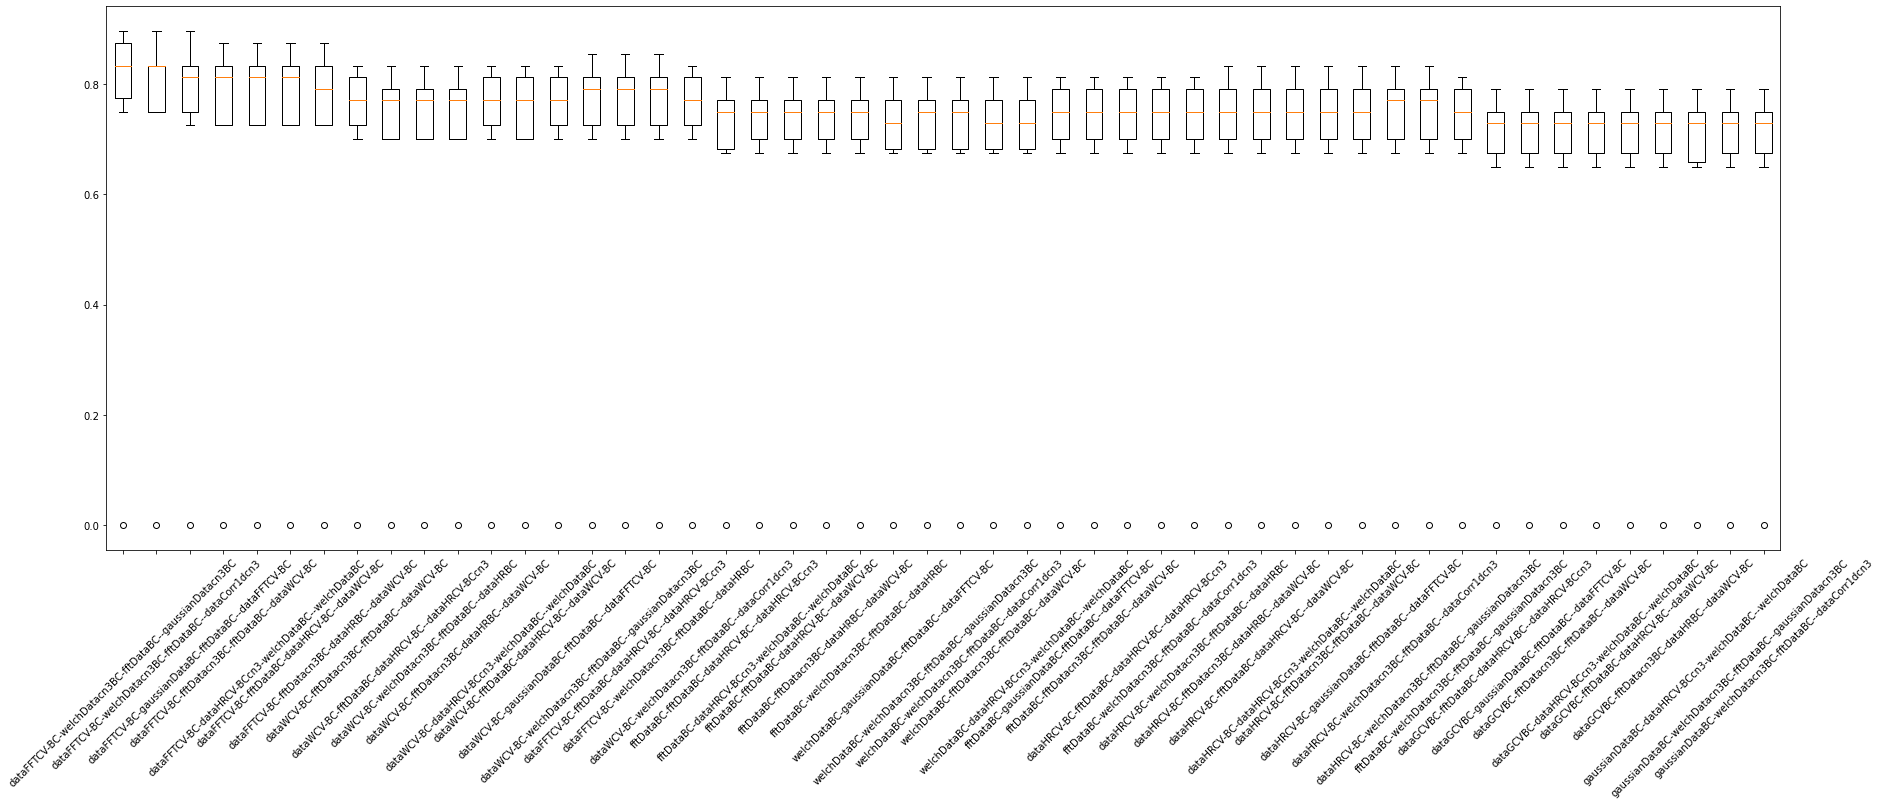

In [546]:
import matplotlib.pyplot as plt
# ordeTopAverage = np.array(np.argsort(comboAverage, axis=1)/(len(combinationList))*len(dataF),dtype=int)
# print(ordeTopAverage)
# print(len(combinationList))
# print(len(dataF))
# print(len(topPerFeature))
# print(len(combinationList)/len(dataF))
#print(ordeTopAverage)

topPerFeature = np.sort(topPerFeature, axis=1)[:,::-1]
indices = np.argsort(topPerFeature, axis=1)[:,::-1][1,:]
print(indices.shape)

#np.argsort(comboAverage, axis=1)
#sortA = np.argsort(topPerFeature, axis = 1)
if len(nameArray) < 100:
    plt.figure(figsize=[30,10])
    plt.boxplot(topPerFeature[1:])
    plt.xticks(np.arange(len(nameArray))+1,nameArray,rotation=45)
    #plt.legend(nameArray)
    print("")
else: 
    plt.figure(figsize=[30,10])
    plt.boxplot(topPerFeature[1:, indices][:,:50])
    plt.xticks(np.arange(len(nameArray[indices][:50]))+1,nameArray[indices][:50],rotation=45)
    #plt.legend(nameArray)
    print("")
    


In [547]:
print("Top ten highest accuracies")

topTen.reverse()
for top in topTen:
    print(
            f"Accuracy {round(top[0],2)} : subject {top[1]}, feature:{top[2]}, kernel{top[3]}, C:{top[4]}"
        )


Top ten highest accuracies
Accuracy 0.9 : subject 5, feature:welchDatacn3BC-welchDatacn3BC-fftDataBC--gaussianDatacn3BC, kernelgini, C:1
Accuracy 0.9 : subject 5, feature:dataWCV-BCcn3-gaussianDataBC-fftDataBC--dataFFTCV-BC, kernelgini, C:1
Accuracy 0.9 : subject 5, feature:dataCorr2ax1dBC-fftDataBC-dataHRCV-BC--dataWCV-BC, kernelgini, C:1
Accuracy 0.9 : subject 4, feature:dataWCV-BCcn3-welchDatacn3BC-fftDataBC--gaussianDatacn3BC, kernelgini, C:1
Accuracy 0.88 : subject 5, feature:welchDataBC-dataHRCV-BCcn3-welchDataBC--welchDataBC, kernelgini, C:1
Accuracy 0.88 : subject 5, feature:iFFTdataCorr2ax1d005s-BC-welchDatacn3BC-fftDataBC--dataCorr1dcn3, kernelgini, C:1
Accuracy 0.88 : subject 5, feature:dataWCV-BCcn3-fftDataBC-dataHRCV-BC--dataWCV-BC, kernelgini, C:1
Accuracy 0.88 : subject 5, feature:dataFFTCV-BC-fftDatacn3BC-fftDataBC--dataWCV-BC, kernelgini, C:1
Accuracy 0.88 : subject 2, feature:welchDatacn3BC-fftDatacn3BC-fftDataBC--dataWCV-BC, kernelgini, C:1
Accuracy 0.88 : subject 2,

In [548]:
# top for each feature

In [549]:
print("Top ten highest accuracies")
#del(topThreeThisSubject[0])
#len(topThreeAllSubjects[0])
for subTop in topThreeAllSubjects:
    subTop.reverse()
topThreeAllSubjects.sort(reverse=True)
arrayOfTopFeatureNames = []
for subTop in topThreeAllSubjects:
    print("")
    #subTop.reverse()
    for top in subTop[:1]:
        arrayOfTopFeatureNames.append(top[2])
        print(
                f"Accuracy {round(top[0],2)} : subject {top[1]}, feature:{top[2]}, kernel{top[3]}, C:{top[4]}"
            )
#print(arrayOfTopFeatureNames)
arrayOfTopFeatureNames = np.array(arrayOfTopFeatureNames, dtype=object)
#print(np.array(arrayOfTopFeatureNames, dtype=object).shape)
newArrayOfTopFeatureNames = []
for topNames in arrayOfTopFeatureNames:
    temp = topNames.replace("--","-")
    temp2 = temp.replace("-B","%")
    splitArray = np.array(temp2.split("-"),dtype=object)
    for ind, stri in enumerate(splitArray):
        splitArray[ind] = stri.replace("%","-B")
    skip = False  
    for obj in splitArray:
        #print(obj)
        if obj == "":
            #print("aofafa")
            skip = True
    if skip:
        continue
    #print(splitArray)
    newArrayOfTopFeatureNames.append(splitArray)
    
#print(newArrayOfTopFeatureNames)
newArrayOfTopFeatureNames = np.array(newArrayOfTopFeatureNames, dtype=object) 
#saveTopName = "top2udrli"
if saveTopName is not None:
    #print(newArrayOfTopFeatureNames)
    np.save(f"topFeatures/{saveTopName}", newArrayOfTopFeatureNames)
    print("TopFeatureNameArraySaved")
    print(newArrayOfTopFeatureNames)


Top ten highest accuracies

Accuracy 0.9 : subject 5, feature:dataWCV-BCcn3-gaussianDataBC-fftDataBC--dataFFTCV-BC, kernelgini, C:1

Accuracy 0.9 : subject 4, feature:dataWCV-BCcn3-welchDatacn3BC-fftDataBC--gaussianDatacn3BC, kernelgini, C:1

Accuracy 0.88 : subject 7, feature:dataHRCV-BC-fftDatacn3BC-dataHRBC--dataWCV-BC, kernelgini, C:1

Accuracy 0.88 : subject 2, feature:welchDatacn3BC-fftDatacn3BC-fftDataBC--dataWCV-BC, kernelgini, C:1

Accuracy 0.83 : subject 9, feature:dataHRCV-BC-welchDatacn3BC-fftDataBC--dataCorr1dcn3, kernelgini, C:1

Accuracy 0.8 : subject 1, feature:iFFTdataCorr1d02s-BC-fftDataBC-dataHRCV-BC--dataWCV-BC, kernelgini, C:1

Accuracy 0.78 : subject 8, feature:dataCorr1d02sBC-dataHRCV-BCcn3-welchDataBC--welchDataBC, kernelgini, C:1

Accuracy 0.75 : subject 6, feature:dataGCVBC-fftDatacn3BC-dataHRBC--dataWCV-BC, kernelgini, C:1
TopFeatureNameArraySaved
[['dataWCV-BCcn3' 'gaussianDataBC' 'fftDataBC' 'dataFFTCV-BC']
 ['dataWCV-BCcn3' 'welchDatacn3BC' 'fftDataBC' 'ga

In [550]:
subjAv = np.zeros(subjectResultArray.shape[0])
for s, subj in enumerate(subjectResultArray):
    subjAv[s] = 0
    if all(subj == None):
        continue
    subjAv[s] = np.mean(subj[np.where(subj != None)])
print(subjAv)
pd.set_option("display.max_columns", None)
table = pd.DataFrame(np.array(comboAverage), columns=headers)
display(table)

print(
    f"Max average accuracy {np.max(np.array(comboAverage[np.where(np.isnan(comboAverage)==False)]))}"
)
maxVal = np.max(np.array(comboAverage[np.where(np.isnan(comboAverage) == False)]))
maxInd = int(np.where(comboAverage == maxVal)[1][0])
# print(headers[maxInd])
# print(nrOfSubjects[maxInd])
# print(list(nameDict.keys())[combinationList[maxInd][0]])
# print(list(kernelDict.keys())[combinationList[maxInd][1]])
# print(f"C: {combinationList[maxInd][2]}")


[0.         0.57916667 0.67022156 0.         0.66468254 0.71577381
 0.59767316 0.66889881 0.60962302 0.64575066]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251
0,0.615057,0.635227,0.660606,0.609848,0.621733,0.544366,0.662547,0.694792,0.69304,0.611932,0.640152,0.662311,0.674953,0.624858,0.648295,0.632765,0.639678,0.649953,0.657434,0.685227,0.600568,0.710653,0.652888,0.675379,0.690767,0.62036,0.665246,0.652604,0.690199,0.680682,0.708144,0.570881,0.572822,0.677509,0.60322,0.664205,0.656818,0.602652,0.601705,0.658381,0.708665,0.69053,0.690436,0.590483,0.640009,0.618845,0.643845,0.65554,0.614867,0.666761,0.688068,0.612879,0.616335,0.678504,0.688589,0.636316,0.688305,0.642377,0.577983,0.642235,0.670312,0.640436,0.663258,0.569981,0.695881,0.644602,0.632812,0.621733,0.689915,0.675189,0.622348,0.601468,0.612121,0.662547,0.554025,0.601562,0.682576,0.676562,0.67197,0.622206,0.598769,0.606581,0.618703,0.592614,0.667045,0.560133,0.582907,0.630066,0.672775,0.595407,0.662879,0.648106,0.654782,0.673343,0.675616,0.673864,0.666998,0.665009,0.66392,0.637926,0.666004,0.687121,0.670691,0.662784,0.691051,0.677794,0.716241,0.647254,0.589867,0.704214,0.66804,0.635038,0.591193,0.642282,0.721638,0.634991,0.683665,0.66785,0.625189,0.60696,0.635369,0.683097,0.605256,0.623248,0.606297,0.683144,0.621686,0.659754,0.679545,0.538068,0.610322,0.591856,0.647254,0.634943,0.688684,0.606676,0.66965,0.609138,0.665814,0.697348,0.67964,0.66785,0.667945,0.667566,0.635133,0.696733,0.543939,0.556581,0.570644,0.667756,0.66392,0.666809,0.713636,0.617519,0.656345,0.679593,0.722491,0.685227,0.719176,0.680824,0.658996,0.624858,0.674811,0.673958,0.619555,0.659233,0.647491,0.633996,0.679545,0.658239,0.6116,0.685606,0.68054,0.546591,0.654782,0.632102,0.626705,0.641193,0.708949,0.676989,0.687311,0.650616,0.649621,0.656866,0.642992,0.666098,0.69143,0.638116,0.661648,0.550047,0.650331,0.655445,0.654356,0.594271,0.680919,0.617093,0.631345,0.605256,0.680587,0.61965,0.648816,0.626278,0.680019,0.700047,0.681392,0.685085,0.653125,0.703598,0.657244,0.53892,0.635985,0.692566,0.674337,0.65142,0.66392,0.713684,0.470549,0.643087,0.489157,0.52358,0.559422,0.596259,0.281345,0.438068,0.61572,0.63892,0.66714,0.666477,0.656487,0.563636,0.574574,0.657055,0.645312,0.697727,0.66785,0.668561,0.652462,0.685322,0.693087,0.683617,0.704735,0.664394,0.6259,0.662121,0.649763,0.648769,0.652036,0.648532,0.659328,0.672775,0.612737,0.681392


Max average accuracy 0.7224905303030303


In [551]:
#np.argpartition(comboAverage, -4)
#print(headers[comboAverage.argsort()[0][-5:][::-1]])
top5 = headers[comboAverage.argsort()[0][-5:][::-1]]
top5Vals = comboAverage[0][comboAverage.argsort()[0][-5:][::-1]]
for maxInd,res in zip(top5, top5Vals):
    print(list(nameDict.keys())[combinationList[maxInd][0]])
    print(list(kernelDict.keys())[combinationList[maxInd][1]])
    print(res)
    print()

dataCorr2ax1dBC-fftDatacn3BC-fftDataBC--dataWCV-BC
gini
0.7224905303030303

iFFTdataCorr1d005s-BC-fftDatacn3BC-dataHRBC--dataWCV-BC
gini
0.7216382575757576

dataCorr2ax1dBC-fftDataBC-dataHRCV-BC--dataWCV-BC
gini
0.7191761363636363

iFFTdataCorr1d02s-BC-welchDatacn3BC-fftDataBC--dataHRBC
gini
0.7162405303030304

welchDatacn3BC-fftDataBC-dataHRCV-BC--dataHRCV-BCcn3
gini
0.7136837121212121



In [552]:
#np.argpartition(comboAverage, -4)
#print(headers[comboAverage.argsort()[0][-5:][::-1]])
top5 = headers[comboTotal.argsort()[0][-5:][::-1]]
top5Vals = comboTotal[0][comboTotal.argsort()[0][-5:][::-1]] /9
for maxInd,res in zip(top5, top5Vals):
    print(list(nameDict.keys())[combinationList[maxInd][0]])
    print(list(kernelDict.keys())[combinationList[maxInd][1]])
    print(res)
    print()

dataCorr2ax1dBC-fftDatacn3BC-fftDataBC--dataWCV-BC
gini
0.6422138047138047

iFFTdataCorr1d005s-BC-fftDatacn3BC-dataHRBC--dataWCV-BC
gini
0.641456228956229

dataCorr2ax1dBC-fftDataBC-dataHRCV-BC--dataWCV-BC
gini
0.6392676767676767

iFFTdataCorr1d02s-BC-welchDatacn3BC-fftDataBC--dataHRBC
gini
0.6366582491582492

welchDatacn3BC-fftDataBC-dataHRCV-BC--dataHRCV-BCcn3
gini
0.6343855218855219



In [553]:
table = pd.DataFrame(np.array(comboTotal), columns=headers)
display(table)

maxVal2 = np.max(np.array(comboTotal[np.where(np.isnan(comboTotal) == False)]))

for maxInd2 in np.where(comboTotal == maxVal2)[1]:

    # maxInd2 = int(np.where(comboTotal == maxVal2)[1])
    print(headers[maxInd2])
    print(nrOfSubjects[maxInd2])
    print(
        f"Max total significant accuracy then averaged {maxVal2/nrOfSubjects[maxInd2]} "
    )

    print(list(nameDict.keys())[combinationList[maxInd2][0]])
    print(list(kernelDict.keys())[combinationList[maxInd2][1]])
    print(f"C: {combinationList[maxInd2][2]} ")


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251
0,4.920455,5.081818,5.284848,4.878788,4.973864,4.354924,5.300379,5.558333,5.544318,4.895455,5.121212,5.298485,5.399621,4.998864,5.186364,5.062121,5.117424,5.199621,5.25947,5.481818,4.804545,5.685227,5.223106,5.40303,5.526136,4.962879,5.32197,5.220833,5.521591,5.445455,5.665152,4.567045,4.582576,5.420076,4.825758,5.313636,5.254545,4.821212,4.813636,5.267045,5.669318,5.524242,5.523485,4.723864,5.120076,4.950758,5.150758,5.244318,4.918939,5.334091,5.504545,4.90303,4.930682,5.42803,5.508712,5.09053,5.506439,5.139015,4.623864,5.137879,5.3625,5.123485,5.306061,4.559848,5.567045,5.156818,5.0625,4.973864,5.519318,5.401515,4.978788,4.811742,4.89697,5.300379,4.432197,4.8125,5.460606,5.4125,5.375758,4.977652,4.790152,4.852652,4.949621,4.740909,5.336364,4.481061,4.663258,5.04053,5.382197,4.763258,5.30303,5.184848,5.238258,5.386742,5.404924,5.390909,5.335985,5.320076,5.311364,5.103409,5.32803,5.49697,5.36553,5.302273,5.528409,5.422348,5.729924,5.17803,4.718939,5.633712,5.344318,5.080303,4.729545,5.138258,5.773106,5.079924,5.469318,5.342803,5.001515,4.855682,5.082955,5.464773,4.842045,4.985985,4.850379,5.465152,4.973485,5.27803,5.436364,4.304545,4.882576,4.734848,5.17803,5.079545,5.50947,4.853409,5.357197,4.873106,5.326515,5.578788,5.437121,5.342803,5.343561,5.34053,5.081061,5.573864,4.351515,4.452652,4.565152,5.342045,5.311364,5.33447,5.709091,4.940152,5.250758,5.436742,5.779924,5.481818,5.753409,5.446591,5.27197,4.998864,5.398485,5.391667,4.956439,5.273864,5.179924,5.07197,5.436364,5.265909,4.892803,5.484848,5.444318,4.372727,5.238258,5.056818,5.013636,5.129545,5.671591,5.415909,5.498485,5.204924,5.19697,5.254924,5.143939,5.328788,5.531439,5.104924,5.293182,4.400379,5.202652,5.243561,5.234848,4.754167,5.447348,4.936742,5.050758,4.842045,5.444697,4.957197,5.19053,5.010227,5.440152,5.600379,5.451136,5.480682,5.225,5.628788,5.257955,4.311364,5.087879,5.54053,5.394697,5.211364,5.311364,5.70947,3.764394,5.144697,3.913258,4.188636,4.475379,4.770076,2.250758,3.504545,4.925758,5.111364,5.337121,5.331818,5.251894,4.509091,4.596591,5.256439,5.1625,5.581818,5.342803,5.348485,5.219697,5.482576,5.544697,5.468939,5.637879,5.315152,5.007197,5.29697,5.198106,5.190152,5.216288,5.188258,5.274621,5.382197,4.901894,5.451136


156
8.0
Max total significant accuracy then averaged 0.7224905303030303 
dataCorr2ax1dBC-fftDatacn3BC-fftDataBC--dataWCV-BC
gini
C: 1 


In [554]:
# maxAcc = np.max([res for res in np.array(
#     subjectResultArray[subjectResultArray != None])])
# print(f"Max single accuracy position {np.where(subjectResultArray == maxAcc)}")
# print(np.max([res for res in np.array(
#     subjectResultArray[subjectResultArray != None])]))
